In [1]:
import math
from math import sqrt

import numpy as np
from numpy.linalg import inv
from numpy.linalg import eig

import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import minimize

from cosmoTransitions import generic_potential
from cosmoTransitions import transitionFinder as tF

In [2]:
g = .649368
gp = .357880
mt = 165.3
v = 246.
#a1 = 0.

In [3]:
class n2hdm_tsq(generic_potential.generic_potential):
    
    def init(self, mh = 125., mH = 400., mA = 400., mHc = 400., m3in = 200., tb = 1., cbma = 0., ms = 130., lS = 1., lbeta = 0.5, lS2 = 1.5*0.5, lS3 = complex(0.,0.115), l6 = 0., l7 = 0.):
    
        # The init method is called by the genericpotential class, after it
        # already does some of its own initialization in the default init()
        # method. This is necessary for all subclasses to implement.

        # This first line is absolutely essential in all subclasses.
        # It specifies the number of field-dimensions in the theory.
        self.Ndim = 4

        # self.renormScaleSq is the renormalization scale used in the
        # Coleman-Weinberg potential.
        self.renormScaleSq = v**2

        # This next block sets all of the parameters that go into the potential
        # and the masses. This will obviously need to be changed for different
        # models.
        self.lS = lS
        self.lS1 = ( 1 + tb**2 ) * lbeta - lS2 * tb**2 - lS3.real * tb**2
        self.lS2 = lS2
        self.lS3 = lS3
        self.l6 = l6
        self.l7 = l7
        self.tb = tb
        self.m32 = ( mH**2 -m3in**2 ) / ( tb + 1. / tb );
        
        self.mS2 = ms**2 - lbeta * v**2;
        self.m12 = self.m32 * tb - .5 * ( mh**2 + ( mH**2 - mh**2 ) * cbma * ( cbma + sqrt( 1. - cbma**2 ) * tb ) );
        self.m22 = self.m32 / tb - .5 * ( mh**2 + ( mH**2 - mh**2 ) * cbma * ( cbma - sqrt( 1. - cbma**2 ) / tb ) );
        self.l1 = mh**2 - tb * ( self.m32 - mH**2 / ( tb + 1./tb ) ) * ( tb**2 + 1. ) + ( mh**2 - mH**2 ) * ( cbma**2 * ( tb**2 - 1. ) - 2. * tb * cbma * sqrt(1.-cbma**2) )
        self.l1/=v**2;
        self.l2 = mh**2 - ( self.m32 - mH**2 / ( tb + 1./tb ) ) * ( 1. / tb**2 + 1. ) / tb + ( mh**2 - mH**2 ) * ( cbma**2 * ( 1. / tb**2 - 1. ) - 2. / tb * cbma * sqrt(1.-cbma**2) )
        self.l2/=v**2;
        self.l3 = mh**2 + 2 * mHc**2 - 2 * mH**2 - ( self.m32 - mH**2 / ( tb + 1./tb ) ) * ( tb + 1./tb ) - ( mh**2 - mH**2 ) * ( 2. * cbma**2 + cbma * sqrt(1.-cbma**2) * ( tb + 1./tb ) )
        self.l3/=v**2;
        self.l4 = mA**2 - 2 * mHc**2 + mH**2 + ( self.m32 - mH**2 / ( tb + 1./tb ) ) * ( tb + 1./tb )
        self.l4/=v**2;
        self.l5 = mH**2 - mA**2 + ( self.m32 - mH**2 / ( tb + 1./tb ) ) * ( tb + 1./tb )
        self.l5/=v**2;

    def forbidPhaseCrit(self, X):
        """
        forbidPhaseCrit is useful to set if there is, for example, a Z2 symmetry
        in the theory and you don't want to double-count all of the phases. In
        this case, we're throwing away all phases whose zeroth (since python
        starts arrays at 0) field component of the vev goes below -5. Note that
        we don't want to set this to just going below zero, since we are
        interested in phases with vevs exactly at 0, and floating point numbers
        will never be accurate enough to ensure that these aren't slightly
        negative.
        """
        return (np.array([X])[...,0] < -5. or np.array([X])[...,1] < -5. or np.array([X])[...,2] < -5. or np.array([X])[...,3] < -5.).any()

    def Vtot(self, X, T, include_radiation=True):
        """
        This method defines the tree-level potential. It should generally be
        subclassed. (You could also subclass Vtot() directly, and put in all of
        quantum corrections yourself).
        """
        # X is the input field array. It is helpful to ensure that it is a
        # numpy array before splitting it into its components.
        X = np.asanyarray(X)
        # x and y are the two fields that make up the input. The array should
        # always be defined such that the very last axis contains the different
        # fields, hence the ellipses.
        # (For example, X can be an array of N two dimensional points and have
        # shape (N,2), but it should NOT be a series of two arrays of length N
        # and have shape (2,N).)
        
        #p1, p2, s, delta = X[...,0], X[...,1], X[...,2], X[...,3]
        #
        #mh2 = ( 3.*self.l1 + 2.*self.l3 + self.l4 + self.lS1 ) * p1**2 + (3.*self.l2 + 2.*self.l3 + self.l4 + self.lS2) * p2**2 + (3.*self.lS + 4.*(self.lS1 + self.lS2)) * s**2 + self.lS3 * p1 * p2 * np.sin(delta)
        #mw2 = g**2*(p1*p1+p2*p2)/4.
        #mz2 = (g**2+gp**2)*(p1*p1+p2*p2)/4.
        #mt2 = (mt/v)**2 * (1+1./self.tb**2) * (p2*p2)
        #
        #r = .5 * ( self.m12*p1**2 + self.m22*p2**2 ) - self.m32*p1*p2*np.cos(delta)
        ##print('V0: r1', r)
        #r += .125 * ( self.l1*p1**4 + self.l2*p2**4 ) + .25 * (self.l3+self.l4)*p1**2*p2**2
        ##print('V0: r2', r)
        #r += .5 * self.mS2*s**2 + 0.25 * self.lS*s**4
        ##print('V0: r3', r)
        #r += .5 * ( self.lS1*p1**2*s**2 + self.lS2*p2**2*s**2 + self.lS3*p1*p2*np.sin(delta)*s**2 )
        ##print('V0: r4', r)
        #r += (T**2)/24. * ( mh2 + 3. * ( 2. * ( mw2 + mt2 ) + mz2 ) )
        ##print('V0: r5', r)
        #return r
    
    
        h1, h2, a2, s = X[...,0], X[...,1], X[...,2], X[...,3]
        phi1, phi2 = h1/sqrt(2), (h2+a2*1j)/sqrt(2)
        phi1C, phi2C = np.conj(phi1), np.conj(phi2)
        
        mh2 = 2.*( 3.*self.l1 + 2.*self.l3 + self.l4 + self.lS1 ) * phi1C*phi1 + 2.*(3.*self.l2 + 2.*self.l3 + self.l4 + self.lS2) * phi2C*phi2 + (3.*self.lS + 4.*(self.lS1 + self.lS2)) * s**2 + self.lS3*phi1C*phi2 + np.conj(self.lS3*phi1C*phi2)
        mw2 = g**2*(phi1C*phi1 + phi2C*phi2)/2.
        mz2 = (g**2+gp**2)*(phi1C*phi1 + phi2C*phi2)/2.
        mt2 = 2.*(mt/v)**2 * (1+1./self.tb**2) * phi2C*phi2
        
        hc = ( .5*self.l5*phi1C*phi2 + self.l6*phi1C*phi1 + self.l7*phi2C*phi2 ) * phi1C*phi2 + .5 * self.lS3*phi1C*phi2*s*s - self.m32*phi1C*phi2
        hc += np.conj(hc)
        #print(hc)
        
        r = .5 * ( self.l1*phi1C*phi1*phi1C*phi1 + self.l2*phi2C*phi2*phi2C*phi2 )
        #print('V0: r1', r)
        r += self.l3*phi1C*phi1*phi2C*phi2 + self.l4*phi1C*phi2*phi2C*phi1
        #print('V0: r2', r)
        r += 0.25*self.lS*s*s*s*s + self.lS1*phi1C*phi1*s*s + self.lS2*phi2C*phi2*s*s
        #print('V0: r3', r)
        r += self.m12*phi1C*phi1 + self.m22*phi2C*phi2 + .5 * self.mS2*s*s
        #print('V0: r4', r)
        r += hc
        #print('V0: r5', r.real)
        r += (T**2)/24. * ( mh2 + 3. * ( 2. * ( mw2 + mt2 ) + mz2 ) )
        #print('V0: r6', r.real)
        return r.real
    
    
        #h1, h2, a2, s = X[...,0], X[...,1], X[...,2], X[...,3]
        #
        #mh2 = ( 3.*self.l1 + 2.*self.l3 + self.l4 + self.lS1 ) * (h1**2+a1**2) + (3.*self.l2 + 2.*self.l3 + self.l4 + self.lS2) * (h2**2+a2**2) + (3.*self.lS + 4.*(self.lS1 + self.lS2)) * s**2 + self.lS3.imag * (a1*h2-h1*a2)
        #mw2 = g**2*(h1*h1+a1*a1+h2*h2+a2*a2)/4.
        #mz2 = (g**2+gp**2)*(h1*h1+a1*a1+h2*h2+a2*a2)/4.
        #mt2 = (mt/v)**2 * (1+1./self.tb**2) * (h2*h2+a2*a2)
        ##print(self.lS3.imag*(a1*h2-h1*a2)*s**2 - self.m32*(h1*h2+a1*a2))
        #
        #r = .5 * ( self.m12*(h1**2+a1**2) + self.m22*(h2**2+a2**2) ) - self.m32*(h1*h2+a1*a2)
        ##print('V0: r1', r)
        #r += .125 * ( self.l1*(h1**2+a1**2)**2 + self.l2*(h2**2+a2**2)**2 ) + .25 * (self.l3+self.l4)*(h1**2+a1**2)*(h2**2+a2**2)
        ##print('V0: r2', r)
        #r += .5 * self.mS2*s**2 + 0.25 * self.lS*s**4
        ##print('V0: r3', r)
        #r += .5 * ( self.lS1*(h1**2+a1**2)*s**2 + self.lS2*(h2**2+a2**2)*s**2 + self.lS3.imag*(a1*h2-h1*a2)*s**2 )
        ##print('V0: r4', r.real)
        #r += (T**2)/24. * ( mh2 + 3. * ( 2. * ( mw2 + mt2 ) + mz2 ) )
        #print('V0: r5', r.real)
        #return r

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        
        return [np.array([v/2**.5, v/2**.5, 0., 0.])]

def makePlots(m=None):
    import matplotlib.pyplot as plt
    if m is None:
        m = n2hdm_tsq()
        m.findAllTransitions()
    # --
    plt.figure()
    m.plotPhasesPhi()
    plt.axis([0,400,-50,400])
    plt.title("Minima as a function of temperature")
    plt.show()
    # --
    plt.figure()
    #T = 0
    T = m.TcritTrans[1]['Tcrit']
    plt.title("$T = %0.2f$" % T)
    plt.xlabel(R"$h_1$")
    plt.ylabel(R"$s$")
    m.plot2dJMC((0,300,0,200), T=T, cfrac=.6,clevs=30,n=1000,linewidths=.5)

    plt.figure()
    T = m.TnTrans[1]['Tnuc']
    if m.TnTrans[1]['instanton'] is not None:
        instanton = m.TnTrans[1]['instanton']
        phi = instanton.Phi
        plt.plot(phi[:,0], phi[:,3], 'k')
    plt.title("$T = %0.2f$" % T)
    plt.xlabel(R"$h_1$")
    plt.ylabel(R"$s$")
    m.plot2dJMC((0,300,0,200), T=T, cfrac=.9,clevs=30,n=1000,linewidths=.5)
    
    if m.TnTrans[1]['instanton'] is not None:
        plt.figure()
        plt.plot(instanton.profile1D.R, instanton.profile1D.Phi)
        plt.xlabel("radius")
        plt.ylabel(R"$\phi-\phi_{min}$ (along the path)")
        plt.title("Tunneling profile")

In [4]:
m = n2hdm_tsq()

In [5]:
pdatbf = np.array(pd.read_csv('/home/jmc/Software/PhaseTracer/build/NZ2HDM_Tsq_4.dat'))
nfds = 4
nphs = 3

pdat = np.zeros(shape = (len(pdatbf), nfds+2, nphs))
k = 0
for i in range(len(pdat)):
    pabf = np.fromstring(pdatbf[i,0], dtype=float, sep=' ')
    if pabf.shape[0] != nfds+2:
        k+=1
        continue
    pdat[i,:,k] = pabf

#p2dat = np.c_[ pdat[:,:,0], np.zeros(len(pdat)) ]
#p1dat = np.c_[ pdat[:,:,1], np.zeros(len(pdat)) ]
#p0dat = np.c_[ pdat[:,:,2], np.zeros(len(pdat)) ]
#nfds+=1

p2dat = pdat[:,:,0]
p1dat = pdat[:,:,1]
p0dat = pdat[:,:,2]

i=0
while i < len(p0dat):
    if p0dat[i,0]==p0dat[i,1] and p0dat[i,0]==0:
        p0dat=np.delete(p0dat,i,0)
        continue
    i+=1

i=1
while i < len(p0dat):
    if p0dat[i,0]==p0dat[i-1,0]:
        p0dat=np.delete(p0dat,i,0)
        continue
    i+=1

i=0
while i < len(p1dat):
    if p1dat[i,0]==p1dat[i,1] and p1dat[i,0]==0:
        p1dat=np.delete(p1dat,i,0)
        continue
    i+=1

i=1
while i < len(p1dat):
    if p1dat[i,0]==p1dat[i-1,0]:
        p1dat=np.delete(p1dat,i,0)
        continue
    i+=1

i=0
while i < len(p2dat):
    if p2dat[i,0]==p2dat[i,1] and p2dat[i,0]==0:
        p2dat=np.delete(p2dat,i,0)
        continue
    i+=1

i=1
while i < len(p2dat):
    if p2dat[i,0]==p2dat[i-1,0]:
        p2dat=np.delete(p2dat,i,0)
        continue
    i+=1

<ipython-input-5-7cd5bc9308e4>:8: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  pabf = np.fromstring(pdatbf[i,0], dtype=float, sep=' ')


In [6]:
##print(p0dat)
#p0dat[:,2:5]=-p0dat[:,2:5]
##print(p0dat)
##print(p1dat)
##print(p2dat)

In [7]:
#for k in range(nphs):
#    for j in range(nfds+2):
#        for i in range(len(pdat)):
    
pdict={0:tF.Phase(key=0,X=p0dat[:,2:nfds+2],T=p0dat[:,0],dXdT=np.zeros([len(p0dat),4])),
       1:tF.Phase(key=1,X=p1dat[:,2:nfds+2],T=p1dat[:,0],dXdT=np.zeros([len(p1dat),4])),
       2:tF.Phase(key=2,X=p2dat[:,2:nfds+2],T=p2dat[:,0],dXdT=np.zeros([len(p2dat),4]))}
#pdict[0].addLinkFrom(pdict[1])
pdict[1].addLinkFrom(pdict[2])

In [8]:
m.phases = pdict
#m.TnTrans = tF.findAllTransitions(pdict, m.Vtot, m.gradV, tunnelFromPhase_args={"phitol":1e-08})
m.TnTrans = tF.findAllTransitions(pdict, m.Vtot, m.gradV)

Tunneling from phase 1 to phase 0 at T=56.782
high_vev = [7.03512017e-04 6.62020797e-04 1.17142646e-05 1.07131784e+02]
low_vev = [ 1.48264359e+02  1.46687902e+02  3.04706805e-02 -9.79061992e-06]
Path deformation converged. 37 steps. fRatio = 1.77294e-02
Path deformation converged. 15 steps. fRatio = 1.95740e-02
Path deformation converged. 1 steps. fRatio = 9.55546e-02
Tunneling from phase 1 to phase 0 at T=56.7825
high_vev = [7.02105275e-04 6.60947307e-04 1.16008997e-05 1.07131630e+02]
low_vev = [ 1.48263862e+02  1.46687381e+02  3.04710261e-02 -9.78506179e-06]
Path deformation converged. 37 steps. fRatio = 1.77288e-02
Path deformation converged. 15 steps. fRatio = 1.96709e-02
Path deformation converged. 1 steps. fRatio = 9.56433e-02
Tunneling from phase 1 to phase 0 at T=73.64245
high_vev = [-9.74789763e-08 -2.43944160e-07  2.92524290e-07  1.00967621e+02]
low_vev = [1.27549875e+02 1.25155039e+02 4.60983383e-02 3.85885134e-05]
Path deformation converged. 54 steps. fRatio = 1.83285e-02
P

In [9]:
m.TcritTrans = tF.findCriticalTemperatures(pdict, m.Vtot)
print(m.TcritTrans)

[{'Tcrit': 151.381, 'low_vev': array([ 9.02875e-06,  7.42878e-06, -3.28422e-08,  1.59172e-05]), 'high_vev': array([ 9.02875e-06,  7.42878e-06, -3.28422e-08,  1.59172e-05]), 'low_phase': 1, 'high_phase': 2, 'action': 0.0, 'instanton': None, 'trantype': 2}, {'Tcrit': 80.06740030278884, 'high_vev': array([1.77157709e-03, 1.67281002e-03, 1.98284676e-05, 9.80734456e+01]), 'high_phase': 1, 'low_vev': array([ 1.16973829e+02,  1.14318561e+02,  5.10027589e-02, -1.14960670e-05]), 'low_phase': 0, 'trantype': 1}]


In [10]:
for key, val in m.TnTrans[1].items():
    if key != 'instanton':
        print(key, ":", val)

low_vev : [1.34465893e+02 1.32298796e+02 4.17698179e-02 1.31564484e-05]
high_vev : [-1.03660500e-07  2.20878044e-07  2.79085248e-07  1.02955551e+02]
Tnuc : 68.76237802980106
low_phase : 0
high_phase : 1
action : 9626.802610317505
trantype : 1


In [207]:
for key, val in m.TnTrans[0].items():
    if key != 'instanton':
        print(key, ":", val)

Tnuc : 151.381
low_vev : [ 5.32035e-06  4.95352e-06  2.21678e-07 -5.65749e-06]
high_vev : [ 5.32035e-06  4.95352e-06  2.21678e-07 -5.65749e-06]
low_phase : 1
high_phase : 2
action : 0.0
trantype : 2


In [208]:
##rdata = instanton.profile1D.R
##phidata = instanton.profile1D.Phi
#
#print(m.TnTrans[1]['instanton'].Phi[-1, :])
#m.TnTrans[1]['instanton'].Phi = np.delete(m.TnTrans[1]['instanton'].Phi, -1, 0)
#print(m.TnTrans[1]['instanton'].Phi[-1, :])

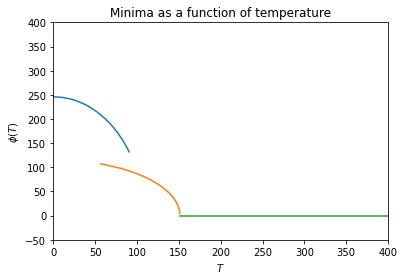

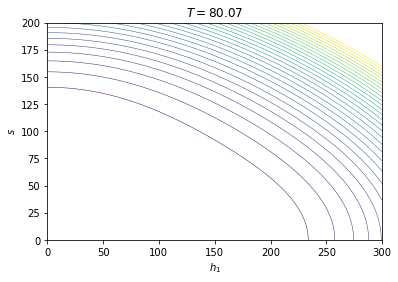

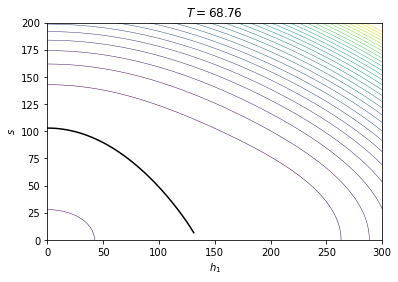

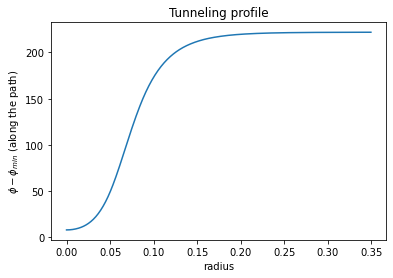

In [209]:
makePlots(m)

In [210]:
instanton=m.TnTrans[1]['instanton']
#print(instanton.profile1D)
#print(instanton.Phi[:,3])
np.savetxt("instanton_Profile_R.txt", instanton.profile1D.R)
np.savetxt("instanton_Profile_Phi.txt", instanton.profile1D.Phi)
np.savetxt("instanton_Phi.txt", instanton.Phi)
np.savetxt("instanton_Phi0.txt", instanton.Phi[:,0], newline=',')

Text(0.5, 1.0, 'Tunneling profile')

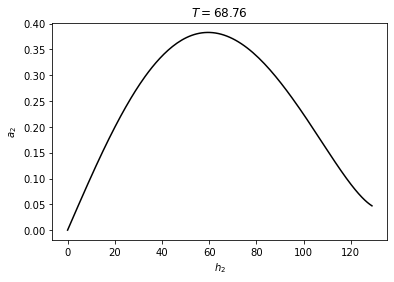

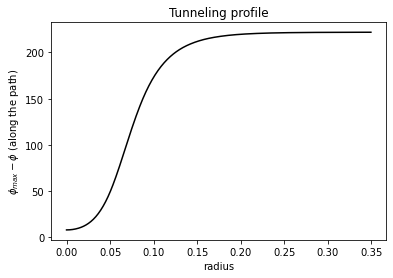

In [218]:
plt.figure()
T = m.TnTrans[1]['Tnuc']
if m.TnTrans[1]['instanton'] is not None:
    instanton = m.TnTrans[1]['instanton']
    phi = instanton.Phi
    plt.plot(phi[:,1], phi[:,2], 'k')
plt.title("$T = %0.2f$" % T)
plt.xlabel(R"$h_2$")
plt.ylabel(R"$a_2$")

rdata = instanton.profile1D.R
phidata = instanton.profile1D.Phi
#phidata = phidata[-1] - phidata
plt.figure()
plt.plot(rdata, phidata, 'k')
plt.xlabel("radius")
plt.ylabel(R"$\phi_{max}-\phi$ (along the path)")
plt.title("Tunneling profile")

In [212]:
#def Kink(r, r0, Lw, Phi0):
#    y = Phi0 * (1 - np.tanh((r-r0)/Lw))
#    return y
#
#parameters, covariance = curve_fit(Kink, rdata, phidata, p0=[0.06,0.06,phidata[0]/2])
#print(parameters)
#
#fit_bubble = Kink(rdata, parameters[0], parameters[1], parameters[2])
#plt.plot(rdata, phidata, 'k', label='bubble')
#plt.plot(rdata, fit_bubble, 'r', label='fit')
#plt.legend()

[0.07616767 0.03839978]


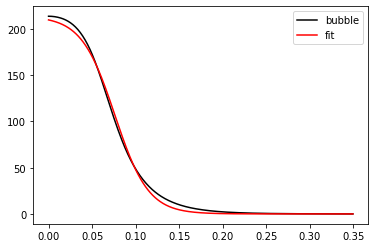

In [213]:
def Kink(r, r0, Lw):
    y = phidata[0]/2 * (1 - np.tanh((r-r0)/Lw))
    return y

parameters, covariance = curve_fit(Kink, rdata, phidata)
print(parameters)

fit_bubble = Kink(rdata, parameters[0], parameters[1])
plt.plot(rdata, phidata, 'k', label='bubble')
plt.plot(rdata, fit_bubble, 'r', label='fit')
plt.legend()
np.savetxt("fit_bubble.txt", fit_bubble)
np.savetxt("phidata.txt", phidata)
np.savetxt("rdata.txt", rdata)

In [214]:
def VtotT(h1,h2,a2,s):
    return m.Vtot([h1,h2,a2,s],T)

potEWmin = minimize(lambda x: VtotT(*x),[100., 100., 0., 0.])
potSmin = minimize(lambda x: VtotT(*x),[0., 0., 0., 100.])

Vmin = potEWmin.fun
vh1c = potEWmin.x[0]
vh2c = potEWmin.x[1]
tbc = 1.
vr1c = vh1c/sqrt(1+tbc**2) + vh2c/sqrt(1+tbc**(-2))
va2c = potEWmin.x[2]
vsc = potSmin.x[3]
print(vr1c)

188.6312037140644


In [215]:
#vr1c = (phi[0,0]-phi[-1,0])/sqrt(1+tbc**2) + (phi[0,1]-phi[-1,1])/sqrt(1+tbc**(-2))
#print(vr1c)

In [217]:
Lw = parameters[1]
xic = vr1c/T
delta = math.atan2(phi[-2,2],phi[-2,1]) - math.atan2(phi[0,2],phi[0,1])
eta11 = 600 * math.sin(delta/2) * xic**2 / (Lw * T)
print(T)
print(delta)
print(xic)
print(Lw)
print(Lw*T)
print(eta11)

68.76238294666182
0.010167665678514732
2.7432325005429705
0.038399776753235
2.640460154172267
8.693331855899894


In [195]:
T=m.TcritTrans[1]['Tcrit']
print(T)

def VtotT(h1,h2,a2,s):
    return m.Vtot([h1,h2,a2,s],T)

potEWmin = minimize(lambda x: VtotT(*x),[100., 100., 0., 0.])
potSmin = minimize(lambda x: VtotT(*x),[0., 0., 0., 100.])

Vmin = potEWmin.fun
vh1c = potEWmin.x[0]
vh2c = potEWmin.x[1]
tbc = 1.
vr1c = vh1c/sqrt(1+tbc**2) + vh2c/sqrt(1+tbc**(-2))
va2c = potEWmin.x[2]
vsc = potSmin.x[3]
print(vr1c)

xic = vr1c/T
print(xic)

80.0674003012882
163.54807386132586
2.0426299997989887


In [67]:






# CT by itself below







In [53]:
pdictCT = m.getPhases()

Tracing phase starting at x = [1.73948265e+02 1.73948265e+02 1.21292467e-07 2.67319256e-07] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [52]:
m.findAllTransitions()

[]

In [129]:
for key, val in m.TnTrans[1].items():
    if key != 'instanton':
        print(key, ":", val)

low_vev : [1.67027812e+02 1.66543121e+02 2.10844578e-06 1.20848957e-07]
high_vev : [ 1.18328713e-06  1.15310686e-06 -3.88125221e-07  1.23770459e+02]
Tnuc : 30.393800461726837
low_phase : 0
high_phase : 3
action : 4255.16135894648
trantype : 1
crit_trans : {'Tcrit': 67.01148273024005, 'high_vev': array([-2.63358564e-04, -2.44994175e-04, -1.08030657e-06,  1.15058443e+02]), 'high_phase': 3, 'low_vev': array([1.36746409e+02, 1.34664432e+02, 1.07648790e-05, 4.08594826e-05]), 'low_phase': 0, 'trantype': 1, 'Delta_rho': 2.3096799850463867e-07}
Delta_rho : 41230714.264394164
Delta_p : 41230714.264394164


In [130]:
for key, val in m.TnTrans[0].items():
    if key != 'instanton':
        print(key, ":", val)

Tnuc : 164.88355323707594
low_vev : [ 4.86325001e-08  3.95949554e-08  4.59863348e-10 -4.45245065e-07]
high_vev : [ 4.86325001e-08  3.95949554e-08  4.59863348e-10 -4.45245065e-07]
low_phase : 3
high_phase : 2
action : 0.0
trantype : 2
crit_trans : {'Tcrit': 164.88355323707594, 'low_vev': array([ 4.86325001e-08,  3.95949554e-08,  4.59863348e-10, -4.45245065e-07]), 'high_vev': array([ 4.86325001e-08,  3.95949554e-08,  4.59863348e-10, -4.45245065e-07]), 'low_phase': 3, 'high_phase': 2, 'action': 0.0, 'instanton': None, 'trantype': 2, 'Delta_rho': 0.0}
Delta_rho : 0.0
Delta_p : 0.0


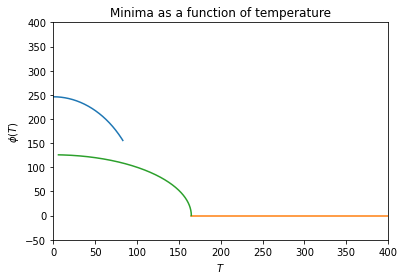

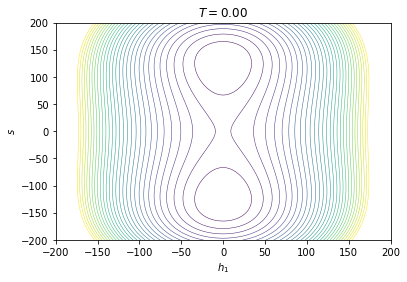

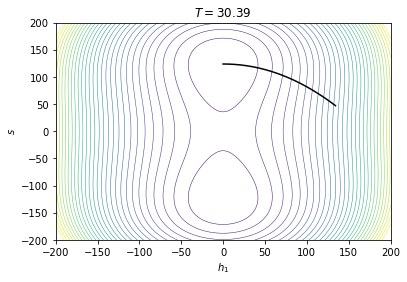

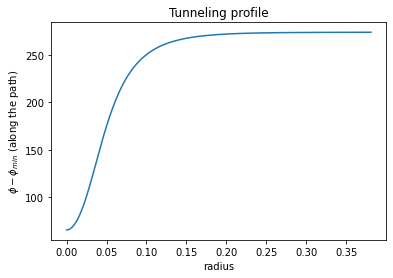

In [131]:
makePlots(m)

In [132]:
print(pdict)
print(pdictCT)

{0: Phase(key=0, X=[[173.9 173.9 1.011e-06 -4.855e-06], ..., [110.8 108 -3.764e-07 -1.54e-05]], T=[0, ..., 83.35], dXdT=[[0 0 0 0], ..., [0 0 0 0]], 1: Phase(key=1, X=[[3.137e-06 1.478e-07 -1.475e-07 1.659e-05], ..., [-3.102e-06 -2.134e-06 1.42e-06 -2.633e-06]], T=[165.3, ..., 1000], dXdT=[[0 0 0 0], ..., [0 0 0 0]], 2: Phase(key=2, X=[[-0.01301 -0.01218 7.3e-06 125.9], ..., [-8.215e-07 -4.068e-07 -3.038e-07 6.251]], T=[0, ..., 164.7], dXdT=[[0 0 0 0], ..., [0 0 0 0]]}
{0: Phase(key=0, X=[[173.9 173.9 1.213e-07 2.673e-07], ..., [111.4 108.7 0.0001606 0.003869]], T=[0, ..., 83.03], dXdT=[[-0 -0 0 -0], ..., [-0 -0 0 0]], 2: Phase(key=2, X=[[4.863e-08 3.959e-08 4.599e-10 -4.452e-07], ..., [4.863e-08 3.959e-08 4.599e-10 -4.452e-07]], T=[164.9, ..., 1000], dXdT=[[0 0 0 0], ..., [-0 -0 -0 0]], 3: Phase(key=3, X=[[-0.0004578 -0.0004387 -5.669e-08 125.8], ..., [1.703e-05 1.569e-05 -1.359e-05 0.3327]], T=[6.139, ..., 164.9], dXdT=[[-0 0 0 0], ..., [-0 -0 0 0]]}


In [139]:
instanton=m.TnTrans[1]['instanton']
#print(instanton.profile1D)
print(instanton.Phi)
np.savetxt("instanton_Profile_R.txt", instanton.profile1D.R)
np.savetxt("instanton_Profile_Phi.txt", instanton.profile1D.Phi)
np.savetxt("instanton_Phi.txt", instanton.Phi)

[[ 1.34270108e+02  1.32742488e+02  4.18691282e-07  4.70833555e+01]
 [ 1.34270108e+02  1.32742488e+02  4.18691360e-07  4.70833562e+01]
 [ 1.34251472e+02  1.32723016e+02  4.20987238e-07  4.71052097e+01]
 ...
 [-1.78349819e-02 -1.66701171e-02  2.07568144e-10  1.23770455e+02]
 [-1.88301148e-02 -1.76002545e-02  2.19045361e-10  1.23770455e+02]
 [-1.98309626e-02 -1.85357336e-02  2.30591864e-10  1.23770454e+02]]
